In [2]:
import numpy as np
import pandas as pd
import random
import sys
import matplotlib.pyplot as plt
%matplotlib inline

sys.path.insert(1,'E:\pro101\python\sepide moradi\codes')

from package.loadDb import *
from package.featureSelection_TENSORIZED import *
from package.featureSelection_TEMPORAL_PAGERANK import *
from package.featureSelection_SICE import *

from package.trmf import *
from package.trmf_regressor import *

from package.regressors import *


In [3]:
import time

In [4]:
# import kaggle dataset
address = "..\database\kaggleDataFrame"

data_with_target= load_kaggle_dataframe(address+"\dataframes.csv")

# data_with_target=data_with_target.iloc[2000:4000]

data_without_target = data_with_target.drop(['DEMAND'],axis=1)

target=data_with_target.iloc[:,-1]
print("data with target size = ",data_with_target.shape )


# # data with target column
# address = "..\database\stock market dataset"
# data_with_target=load_stock_market_dataframe(address+"\sample_normalized_with_target.csv")
# # data_with_target=data_with_target.iloc[:10000]
# data_without_target = data_with_target.drop(['TARGET'],axis=1)
# # data_without_target=data_with_target.iloc[:,:-1]
# target=data_with_target.iloc[:,-1]

data with target size =  (46968, 11)


In [5]:
data_without_target.shape

(46968, 10)

In [6]:
# plt.plot(list(target[:20]))

In [7]:
#segment sizes
interval=2000
testSize=500
#energy of pca to compute number of components
tol=1


In [8]:
#dictionary contains rmse of test set of each segment for all methods
dict_rmse={}
dict_runtime={}

PCA

In [9]:
counter=0
pca_list=[]
num_comp_list=[]
runtime=[]
# while counter+interval <= data_without_target.shape[0]:
for i in range(data_without_target.shape[0]//interval):
    start_index=i*interval
    end_index=start_index+interval

    datacut=data_with_target[start_index:end_index]
    X_datacut=datacut.iloc[:,:-1]
    Y_datacut=datacut.iloc[:,-1]
    # print(counter,X_datacut.shape)
    st = time.time()
    X_transformed,eigenvalues=compute_pca(X_datacut,num_comp=None)
    et = time.time()
    num_comp=energy(eigenvalues,tol)
    X_pca=X_transformed[:,:num_comp]
    
    pca_rmse=xgboost_reg_error(X_pca,Y_datacut,testSize)

    pca_list.append(pca_rmse)##########################
    num_comp_list.append(num_comp)##########################

    elapsed_time = et - st
    runtime.append(elapsed_time)
    

    # counter+=interval
    
dict_rmse['PCA']=pca_list
dict_runtime["PCA_runtime"]=runtime

In [10]:
num_comp_list

[10,
 9,
 9,
 10,
 10,
 10,
 9,
 10,
 10,
 10,
 8,
 9,
 10,
 10,
 9,
 9,
 10,
 10,
 10,
 9,
 10,
 10,
 10]

TRMF

In [11]:
# trmf parameters..............................................
lags = [1,30]
# K = 4######### changes besed on pca energy
lambda_f = 1.
lambda_x = 1
lambda_w = 1.
alpha = 1000.
eta = 1.
max_iteration=10000
# num_comp=K

In [14]:
from joblib import Parallel, delayed
runtime=[]

counter=0
def process(j):
    start_index=j*interval
    end_index=start_index+interval
    
    K=num_comp_list[j]

    data=data_without_target.to_numpy().T

    data=data[:,start_index:end_index]
    target_cut=target.iloc[start_index:end_index]

    T_train = data.shape[1]
    st=time.time()#>>>>>>>>>>>>>>>>>>>>>>
    data_normalized =normalized_data(data, T_train, 0, normalize=True)

    model = trmf(lags, K, lambda_f, lambda_x, lambda_w, alpha, eta)
    model.fit(data_normalized, max_iter = max_iteration)
    et=time.time()#>>>>>>>>>>>>>>>>>>>>>>
    elapsed_time = et - st
    runtime.append(elapsed_time)

    # get reduced data
    new_features=model.X.T
    
    rmse=xgboost_reg_error(new_features,target_cut,testSize)
    
    # counter+=interval
    return rmse
    
trmf_rmse_list = Parallel(n_jobs=2)(delayed(process)(j) for j in range(data_without_target.shape[0]//interval))
dict_rmse['trmf_rmse']=trmf_rmse_list
dict_runtime["TRMF_runtime"]=runtime


TEMPORAL PAGE RANK FEATURE SELECTION

In [18]:
window_size_list=[2,3,5,7,10,30]#

In [19]:
def process_temporal(window_size,j):
    start_index=j*interval
    end_index=start_index+interval

    num_comp=num_comp_list[j]

    datacut=data_with_target[start_index:end_index]
    X_datacut=datacut.iloc[:,:-1]
    Y_datacut=datacut.iloc[:,-1]
    
    arr=create_graph_details(X_datacut,window_size)
    a=featureSelection_tpr(arr,X_datacut.shape[1],num_comp)

    mse_tpr=xgboost_reg_error(X_datacut[X_datacut.columns[a][0]].values,Y_datacut,testSize)
    return mse_tpr

In [20]:
dict_mse_tpr={}
dict_runtime_tpr={}
for window_size in window_size_list :
    method_list = []
    runtime=[]
    method_list = Parallel(n_jobs=2)(delayed(process_temporal)(window_size,j) for j in range(data_without_target.shape[0]//interval))

    dict_mse_tpr["Temp-PR win={}".format(window_size)]=method_list
    dict_runtime_tpr["Temporal-PR win={}".format(window_size)]=runtime


dataframe_1 = pd.DataFrame(dict_mse_tpr)
dict_rmse['temp_PR_rmse']=list(dataframe_1.min(axis=1))
df_time_1=pd.DataFrame(dict_runtime_tpr)
dict_runtime["Temporal_pr_runtime"]=list(df_time_1.mean(axis=1))


In [23]:
def process_temporal1(window_size,j):
    start_index=j*interval
    end_index=start_index+interval

    num_comp=num_comp_list[j]


    datacut=data_with_target[start_index:end_index]
    X_datacut=datacut.iloc[:,:-1]
    Y_datacut=datacut.iloc[:,-1]

    selected_features_index=featureSelection(X_datacut,window_size)

    selected_data= X_datacut[X_datacut.columns[selected_features_index]].to_numpy()
    mse_sice=xgboost_reg_error(selected_data[:,:num_comp],Y_datacut,testSize)



In [24]:
dict_mse_sice={}
dict_runtime_sice={}

for window_size in window_size_list:
    runtime=[]

    i=0
    method_list = Parallel(n_jobs=2)(delayed(process_temporal1)(window_size,j) for j in range(data_without_target.shape[0]//interval))

    dict_mse_sice["sice win={}".format(window_size)]=method_list
    dict_runtime_sice["Static-PR win={}".format(window_size)]=runtime

dataframe_2 = pd.DataFrame(dict_mse_sice)
dict_rmse['static_PR_rmse']=list(dataframe_2.min(axis=1))
df_time_2=pd.DataFrame(dict_runtime_sice)
dict_runtime["Static_pr_runtime"]=list(df_time_2.mean(axis=1))

<AxesSubplot:title={'center':'num_comp=.'}, xlabel='dataframe segments', ylabel='RMSE'>

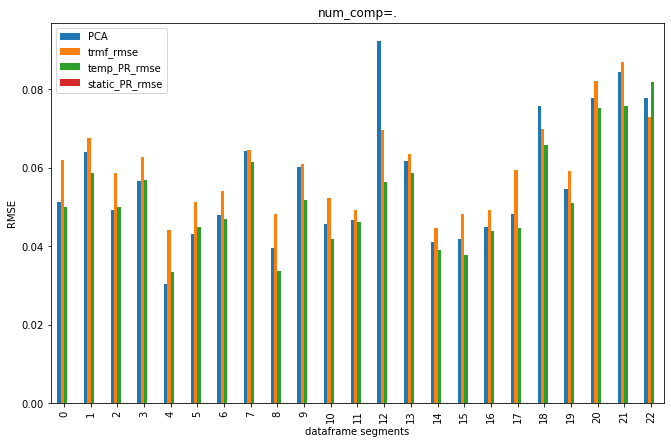

In [25]:
   
dataframe = pd.DataFrame(dict_rmse)
plt.rcParams["figure.figsize"] = [11,7]
dataframe.plot(kind="bar",title="num_comp={}".format("."),ylabel='RMSE',xlabel="dataframe segments")

In [26]:
time_dataframe = pd.DataFrame(dict_runtime)
plt.rcParams["figure.figsize"] = [11,3]
time_dataframe.plot(kind="line",title="{}".format("."),ylabel='Time',xlabel="dataframe segments")


ValueError: All arrays must be of the same length

In [27]:
dataframe.mean()

PCA               0.056463
trmf_rmse         0.059985
temp_PR_rmse      0.052392
static_PR_rmse         NaN
dtype: float64

In [28]:
num_comp_list

[10,
 9,
 9,
 10,
 10,
 10,
 9,
 10,
 10,
 10,
 8,
 9,
 10,
 10,
 9,
 9,
 10,
 10,
 10,
 9,
 10,
 10,
 10]

In [29]:
dataframe.head(30)

,PCA,trmf_rmse,temp_PR_rmse,static_PR_rmse
0,0.051285,0.062001,0.050051,NaN
1,0.064049,0.067423,0.058650,NaN
2,0.049171,0.058496,0.049960,NaN
3,0.056466,0.062571,0.056788,NaN
4,0.030346,0.044055,0.033333,NaN
5,0.043154,0.051177,0.044970,NaN
6,0.047850,0.053910,0.047001,NaN
7,0.064292,0.064509,0.061301,NaN
8,0.039521,0.048143,0.033558,NaN
9,0.060205,0.060906,0.051832,NaN


In [30]:
dataframe.loc['Var'] =list(dataframe.var())
dataframe.loc['Mean'] =list(dataframe.mean())
dataframe.loc['Min'] =list(dataframe.min())
dataframe.loc['Max'] =list(dataframe.max())

In [31]:
dataframe.head(30)


,PCA,trmf_rmse,temp_PR_rmse,static_PR_rmse
0,0.051285,0.062001,0.050051,NaN
1,0.064049,0.067423,0.058650,NaN
2,0.049171,0.058496,0.049960,NaN
3,0.056466,0.062571,0.056788,NaN
4,0.030346,0.044055,0.033333,NaN
5,0.043154,0.051177,0.044970,NaN
6,0.047850,0.053910,0.047001,NaN
7,0.064292,0.064509,0.061301,NaN
8,0.039521,0.048143,0.033558,NaN
9,0.060205,0.060906,0.051832,NaN


In [23]:
# name="kaggle-energy={}".format(tol)
# time_dataframe.to_excel("time-{}.xlsx".format(name))  
# dataframe.to_excel("RMSE-{}.xlsx".format(name))